# Effondrement à symétrie sphérique en cosmologie #

## 1. Introduction ##

Le but de ce projet est de calculer le temps d'effondrement d'une surdensité primordiale dans un univers en expansion. L'évolution de cette surdensité est donnée par l'équation différentielle ci-dessous :
\begin{equation}
	\label{e1}
	\ddot{\delta} + 2H(t)\dot{\delta} = 4\pi G\rho_{m}(t)\delta (1 + \delta) + \dfrac{4}{3} \dfrac{{\dot{\delta}}^2}{1 + \delta}
\end{equation}  
  
où $H(t) = \frac{2}{3t}$ est la constante de Hubble et $\rho_{m}(t) = \Omega_{m} \rho_{c} /a(t) ^{3}$ la densité moyenne de l'univers. $\Omega_{m}$ est la densité actuelle de matière dans l'univers, normalisée par la densité critique $\rho_{c}$  et a(t) le facteur d'expansion de l'univers.
On considerera un univers dit de Einstein - de Sitter, de densité $\Omega_m = 1$. Dans ce projet, servant de résumé et de remise à niveau du projet initial, nous couvrirons :
   - La résolution de l'équation différentielle en régime linéaire 
   - La résolution de l'équation différentielle en régime non-linéaire
   - L'itération sur la surdensité initiale telle que le temps d'effondement soit égal à $t_{eff} = \frac{2}{3H_0}$
   - L'influence des différents paramètres choisis (surdensité initiale $\delta_i$, surdensité d'effondrement $\delta_{eff}$, le pas de temps ...
   - L'effondrement plus *physique*, saturant à la surdensité viriel
   - Nous nous intéresserons également à certaines bibliothèques permettant en théorie de réduire le de temps de calcul

**Imports :**

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import csv
import pandas as pd

**Déclaration des variables**

In [2]:
Mp = 3.08567758 * 1e22                      # Valeur d'un mégaparsec
H0 = 7 * 1e4 / Mp                           # Constante de Hubble Actuelle
G = 6.6742 * 1e-11                          # Constante de gravitation
rho_crit = (3 * H0 ** 2) / (8 * np.pi * G)  # Densité critique
sig = 1                                     # Densité de l'univers
milliard_annee = 3600 * 24 * 365 * 1e9      # Un milliard d'années en secondes

**Conditions initiales :**    
On veut $t_i$ très petit devant $1/H_0$, or $1/H_0 = 4.4e17s$ ( = 13 952 308 472 ans)  
On peut donc prendre $t_i$ = 300 000 ans par exemple  


In [3]:
ti = 300000 * 365 * 24 * 3600
tf = 1 / H0

**Grille de temps :**

In [4]:
N = 5000
ttab = np.linspace(ti, tf, N)
dt = (tf - ti) / N                    # DEFINITION DU PAS DE TEMPS
ttab_milliard = ttab / milliard_annee # Grille de temps en miliards d'années

**Constante de Hubble :**

In [5]:
def H(t):
    return 2 / (3 * t)

**Facteur d'expansion :**

In [6]:
def a(t):
    return (1.5 * H0 * t) ** (2 / 3)

**Densité moyenne :**

In [7]:
def rho_m(t):
    return (sig * rho_crit) / (a(t) ** 3)

## 2. Solution linéaire ##

- On définit la fonction que l'on veut résoudre. On a ici enlevé les termes non-linéaires. On l'écrit également en forme vectorielle pour la résoudre à l'aide de scipy.integrate.odeint

In [8]:
def fonction(delta_et_p, ttab):
    return -2 * H(ttab) * delta_et_p[1] + 1.5 * (H(ttab) ** 2) * delta_et_p[0]

def equation(delta_et_p, ttab):
    return [delta_et_p[1], -2 * H(ttab) * delta_et_p[1] + 1.5 * (H(ttab) ** 2) * delta_et_p[0]]

### Implémentation de Runge-Kutta 

**Runge-Kutta 2**

In [9]:
def rk2_lin(delta_i, delta_eff):
    pi = delta_i * H(ti)
    delta_p = np.zeros((len(ttab), 2))
    delta_p[0, 0], delta_p[0, 1] = delta_i, pi
    temps_eff = 0
    for n in range(1, len(ttab)):
        t = ttab[n]
        
        if (delta_p[n - 1, 0] and delta_p[n - 1, 1]) < delta_eff:
            k1 = -2 * H(t) * delta_p[n - 1, 1] + 1.5 * (H(t) ** 2) * delta_p[n - 1, 0]
            k2 = fonction([delta_p[n - 1, 0], delta_p[n - 1, 1] + dt * k1], t + dt)
            delta_p[n, 1] = delta_p[n - 1, 1] + 0.5 * dt * (k1 + k2)
            delta_p[n, 0] = delta_p[n - 1, 0] + delta_p[n - 1, 1] * dt
        else:
            temps_eff = ttab[n]
            
    return delta_p, temps_eff

**Runge-Kutta 4**

In [10]:
def rk4_lin(delta_i, delta_eff):
    pi = delta_i * H(ti)
    delta_p = np.zeros((len(ttab), 2))
    delta_p[0, 0], delta_p[0, 1] = delta_i, pi
    
    temps_eff = 0
    for n in range(1, len(ttab)):
        t = ttab[n]
        if (delta_p[n - 1, 0] and delta_p[n - 1, 1]) < delta_eff:
            k1 = -2 * H(t) * delta_p[n - 1, 1] + 1.5 * (H(t) ** 2) * delta_p[n - 1, 0]
            k2 = fonction([delta_p[n - 1, 0], delta_p[n - 1, 1] + (dt * k1) / 2], t + dt / 2)
            k3 = fonction([delta_p[n - 1, 0], delta_p[n - 1, 1] + (dt * k2) / 2], t + dt / 2)
            k4 = fonction([delta_p[n - 1, 0], delta_p[n - 1, 1] + (dt * k3) / 2], t + dt)
            delta_p[n, 1] = delta_p[n - 1, 1] + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)
            delta_p[n, 0] = delta_p[n - 1, 0] + delta_p[n - 1, 1] * dt
        else:
            temps_eff = ttab[n]
    
    return delta_p, temps_eff

In [11]:
def rk4_test(delta_i, delta_eff):
    
    delta_p = np.zeros((len(ttab), 2))
    
    pi = delta_i * H(ti)
    delta_p[0, 0] = delta_i
    delta_p[0, 1] = pi    
    
    n, t, t_final = 1, ttab[1], ttab[-1]

    while t < t_final:

        k1 = fonction([delta_p[n - 1, 0], delta_p[n - 1, 1]], t)
        k2 = fonction([delta_p[n - 1, 0], delta_p[n - 1, 1] + (dt * k1) / 2], t + dt / 2)
        k3 = fonction([delta_p[n - 1, 0], delta_p[n - 1, 1] + (dt * k2) / 2], t + dt / 2)
        k4 = fonction([delta_p[n - 1, 0], delta_p[n - 1, 1] + (dt * k3) / 2], t + dt)
        
        delta_p[n, 1] = delta_p[n - 1, 1] + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)
        delta_p[n, 0] = delta_p[n - 1, 0] + delta_p[n - 1, 1] * dt
        
        t = t + dt
        n += 1
        
    delta_p[delta_p[:, 0] == 0, 0] = delta_eff
    
    return delta_p, t

**Solutions**

In [12]:
%%time
lin_rk2, tlin_rk2 = rk2_lin(1e-3, 1e4)
print('$t_{eff}=$', tlin_rk2)

$t_{eff}=$ 0
Wall time: 143 ms


In [13]:
%%time
lin_rk4, tlin_rk4 = rk4_lin(1e-3, 1e4)
print('Temps eff :', tlin_rk4)

Temps eff : 0
Wall time: 254 ms


In [14]:
%%time
c_i = [1e-3, H(ti) * 1e-3]  # CONDITIONS INITIALES
y = odeint(equation, c_i, ttab)

Wall time: 9 ms


In [17]:
%%time
x_test, t_test = rk4_test(1e-3, 1e4)

Wall time: 227 ms


  


|                       | **Runge-Kutta 2** | **Runge-Kutta 4** |  **Scipy.integrate.odeint** |
|-----------------------|-------------------|-------------------|-----------------------------|
| **Solution :**        |Pas d'effondrement | Pas d'effondrement| Pas d'effondrement          |   
| **Temps de calcul :** |       42 ms       |       82 ms       |          2 ms               | 


**Graphes**

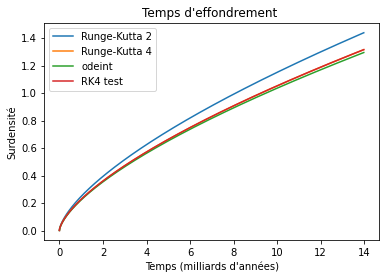

In [18]:
plt.title("Temps d'effondrement ")
plt.plot(ttab_milliard, lin_rk2[:, 0], label='Runge-Kutta 2')
plt.plot(ttab_milliard, lin_rk4[:, 0], label='Runge-Kutta 4')
plt.plot(ttab_milliard, y[:, 0], label='odeint')
plt.plot(ttab_milliard, x_test[:, 0], label='RK4 test')
plt.xlabel("Temps (milliards d'années)")
plt.ylabel("Surdensité")
plt.legend()
plt.show()

## 3. Solution non-linéaire

In [19]:
def fonction_nonlin(delta_et_p, t):
    return -2 * H(t) * delta_et_p[1] + 1.5 * (H(t) ** 2) * delta_et_p[0] * (1 + delta_et_p[0]) + (4 / 3) * (
            (delta_et_p[1] ** 2) / (1 + delta_et_p[0]))

### Implémentation de Runge-Kutta 

**Runge-Kutta 2**

In [20]:
def rk2 (delta_i,delta_eff):
    pi= delta_i * H(ti)
    delta_p=np.zeros((len(ttab),2))
    delta_p[0,0],delta_p[0,1]=delta_i,pi
    for n in range (1,len(ttab)):
        t=ttab[n]
        if (delta_p[n - 1, 0] and delta_p[n - 1, 1]) < delta_eff:  # Condition pour s'assurer que delta ne diverge pas
            k1=-2*H(t)*delta_p[n-1, 1] + 1.5*(H(t)**2)*delta_p[n-1, 0]*(1+delta_p[n-1, 0])\
               +(4/3)*((delta_p[n-1,1]**2)/(1+delta_p[n-1, 0]))
            k2= fonction_nonlin([delta_p[n-1,0],delta_p[n-1,1]+dt*k1],t+dt)
            delta_p[n,1]= delta_p[n-1,1] + 0.5*dt*(k1+k2)
            delta_p[n,0]= delta_p[n-1,0] + delta_p[n-1,1]*dt
        else:
            delta_p[n, 0] = delta_eff + 1
            delta_p[n, 1] = delta_p[n - 1, 1]
    delta_p[delta_p[:, 0] > delta_eff, 0] = delta_eff
    argmax = delta_p[:, 1].argmax()
    delta_p[delta_p[:, 1] > delta_p[argmax - 1, 1], 1] = delta_p[argmax - 1, 1]
    if delta_p[-1,0] != delta_eff:
        temps_eff=0
#         print("La surdensité ne s'est pas encore effondrée ")
    else:
        argmax=delta_p[:,0].argmax()
        temps_eff=ttab[argmax]
        print("Effondrement à ", temps_eff / milliard_annee, "milliards d'années, indice", argmax)
    return (delta_p,temps_eff)


**Runge-Kutta 4**

In [21]:
def rk4(delta_i, delta_eff):
    pi = delta_i * H(ti)
    delta_p = np.zeros((len(ttab), 2))
    delta_p[0, 0], delta_p[0, 1] = delta_i, pi
    for n in range(1, len(ttab)):
        t = ttab[n]
        if (delta_p[n - 1, 0] and delta_p[n - 1, 1]) < delta_eff: # Condition pour s'assurer que delta ne diverge pas
            k1 = -2 * H(t) * delta_p[n - 1, 1] + 1.5 * (H(t) ** 2) * delta_p[n - 1, 0] * (1 + delta_p[n - 1, 0]) \
                 + (4 / 3) * ((delta_p[n - 1, 1] ** 2) / (1 + delta_p[n - 1, 0]))
            k2 = fonction_nonlin([delta_p[n - 1, 0], delta_p[n - 1, 1] + (dt * k1) / 2], t + dt / 2)
            k3 = fonction_nonlin([delta_p[n - 1, 0], delta_p[n - 1, 1] + (dt * k2) / 2], t + dt / 2)
            k4 = fonction_nonlin([delta_p[n - 1, 0], delta_p[n - 1, 1] + (dt * k3) / 2], t + dt)
            delta_p[n, 1] = delta_p[n - 1, 1] + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)
            delta_p[n, 0] = delta_p[n - 1, 0] + delta_p[n - 1, 1] * dt
        else:
            delta_p[n, 0] = delta_eff + 1
            delta_p[n, 1] = delta_p[n - 1, 1]
    delta_p[delta_p[:, 0] > delta_eff, 0] = delta_eff
    argmax = delta_p[:, 1].argmax()
    delta_p[delta_p[:, 1] > delta_p[argmax - 1, 1], 1] = delta_p[argmax - 1, 1]
    if delta_p[-1, 0] != delta_eff:
        temps_eff = 0
#         print("La surdensité ne s'est pas encore effondrée ")
    else:
        argmax = delta_p[:, 0].argmax()
        temps_eff = ttab[argmax]
        print("Effondrement à ", temps_eff / milliard_annee, "milliards d'années, indice", argmax)
    return delta_p, temps_eff


In [22]:
def rk4_modif(delta_i, delta_eff):
    
    delta_p = np.zeros((len(ttab), 2))
    
    pi = delta_i * H(ti)
    delta_p[0, 0] = delta_i
    delta_p[0, 1] = pi    
    
    n, t, t_final = 1, ttab[1], ttab[-1]

    while t < t_final and (delta_p[n - 1, 0] and delta_p[n - 1, 1]) < delta_eff:

        k1 = fonction_nonlin([delta_p[n - 1, 0], delta_p[n - 1, 1]], t)
        k2 = fonction_nonlin([delta_p[n - 1, 0], delta_p[n - 1, 1] + (dt * k1) / 2], t + dt / 2)
        k3 = fonction_nonlin([delta_p[n - 1, 0], delta_p[n - 1, 1] + (dt * k2) / 2], t + dt / 2)
        k4 = fonction_nonlin([delta_p[n - 1, 0], delta_p[n - 1, 1] + (dt * k3) / 2], t + dt)
        
        delta_p[n, 1] = delta_p[n - 1, 1] + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)
        delta_p[n, 0] = delta_p[n - 1, 0] + delta_p[n - 1, 1] * dt
        
        t = t + dt
        n += 1
        
    delta_p[delta_p[:, 0] > delta_eff, 0] = delta_eff   # Les valeurs supérieures à delta_eff sont remises à delta_eff
    delta_p[delta_p[:, 0] == 0, 0] = delta_eff          # Si la boucle pas terminée, on donne valeur delta_eff aux 0
    
    
    return delta_p, t

**Solutions**

In [23]:
%%time
nl_rk2, tnl_rk2 = rk2(1e-2, 1e4) 

Effondrement à  0.6406079921608733 milliards d'années, indice 229
Wall time: 20.1 ms


In [24]:
%%time
nl_rk4, tnl_rk4 = rk4(1e-2, 1e4) 

Effondrement à  0.7021222970846254 milliards d'années, indice 251
Wall time: 39 ms


In [25]:
%%time
nl_rk4_test, nl_t_test = rk4_modif(1e-2, 1e4)

Wall time: 15.7 ms




|                       | **Runge-Kutta 2** | **Runge-Kutta 4** |  **RK4 modifiée**           |
|-----------------------|-------------------|-------------------|-----------------------------|
| **Solution :**        |      0.64         |  0.70             |  0.71                       |   
| **Temps de calcul :** |    9 ms           |      12 ms        |         8 ms                | 


**Graphes**

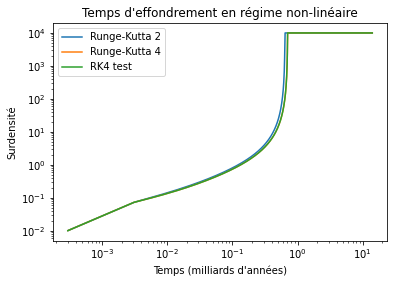

In [26]:
plt.title("Temps d'effondrement en régime non-linéaire")
plt.plot(ttab_milliard, nl_rk2[:, 0], label='Runge-Kutta 2')
plt.plot(ttab_milliard, nl_rk4[:, 0], label='Runge-Kutta 4')
plt.plot(ttab_milliard, nl_rk4_test[:, 0], label='RK4 test')
plt.xlabel("Temps (milliards d'années)")
plt.ylabel('Surdensité')
plt.xscale('log')
plt.yscale('log')
plt.legend() 
plt.show()

## 4. Itérations sur les paramètres

| Temps minimum d'effondrement | Age de l'univers    | Temps maximum d'effondrement |
|------------------------------|---------------------|------------------------------|
| Surdensité maximum           | Surdensité cherchée | Surdensité minimum           |

**On veut donc s'assurer que :**
- Le temps d'effondrement maximal soit supérieur à l'âge de l'univers
- Le temps d'effondrement minimal soit inférieur à l'âge de l'univers

### 1. Surdensité initiale telle que $t_{eff}$ égal l'âge de l'univers

In [ ]:
t_eff = 2 / (3 * H0) # L'âge de l'univers

# TODO : Revoir les conditions 

def cond_init(d_i_min, d_i_max, tolerance, delta_eff, t_eff=t_eff):
    
    # Chercher le temps d'effondrement pour d_i_min:
    sol1, temps_eff_max = rk4_modif(d_i_min, delta_eff)
    print("Temps max d'effondrement", temps_eff_max/milliard_annee)
    if temps_eff_max/milliard_annee > t_eff:   # Si temps d'effondrement pour la plus petite surdensité est inférieur à l'âge de l'univers
        print("Surdensité minimum trop grande")
        return


   # Chercher le temps d'effondrement pour d_i_min:
    sol2, temps_eff_min = rk4_modif(d_i_max, delta_eff)
    print("Temps max d'effondrement", temps_eff_min/milliard_annee)
    
    if t_eff < temps_eff_min/milliard_annee:  # Si temps d'effondrement pour la plus grande surdensité est inférieur à l'âge de l'univers
        print("Surdensité maximum trop grande")
        return

    inter = abs(d_i_max - d_i_min)
    
    while inter > tolerance:
        milieu = (d_i_min + d_i_max) / 2
        sol, temps_moy = rk4_modif(milieu, delta_eff)
        
        if temps_moy > t_eff:
            d_i_min = milieu
        else:
            d_i_max = milieu
            
        inter = d_i_max - d_i_min
        
    surd_init = (d_i_max + d_i_min) / 2
    return surd_init

In [ ]:
%%time
surd_init = cond_init(1e-6, 1e-1, 1e-7, 1e4)
print("Surdensité initiale:", surd_init)

### 2. Itération sur la surdensité initiale $\delta_i$

**TODO :** Enregistrer les résultats dans un même fichier csv

In [ ]:
temps_eff = open("temps_eff.txt", "w")
surdens_init = open("surdensité_initiale.txt", "w")
# On part de la surdensité qui s'effondre à l'âge de l'univers
surd_init = np.linspace(0.001777656936645508, 15 * 0.001777656936645508, 100)
for delta_i in (surd_init):
    z, eff = rk4(delta_i, 1e4)
    temps_eff.write("{}\n".format(str(eff)))
    surdens_init.write("{}\n".format(str(delta_i)))
temps_eff.close()
surdens_init.close()

- On part de la surdensité qui s'effondre à l'âge de l'univers

In [ ]:
surd_init_tab = np.linspace(surd_init, 15 * surd_init, 100)

with open('iter_surd_ini.csv', 'w', newline='') as iter_init:
    titres_colonnes = ['surd_init', 'temps_eff']
    
    csv_writer = csv.DictWriter(iter_init, fieldnames=titres_colonnes, delimiter='\t')
    csv_writer.writeheader()
    
    for delta_i in (surd_init_tab):
        delta, t_eff = rk4_modif(delta_i, 1e4)
        csv_writer.writerow({'surd_init':delta_i, 'temps_eff':t_eff})

In [ ]:
df = pd.read_csv('iter_surd_ini.csv', delimiter='\t')
df.plot(x='surd_init', y='temps_eff')

### 3. Itération sur la surdensité d'effondrement $\delta_{eff}$


In [ ]:
temps_eff = open("temps_deltaeff.txt", "w")
surdens_eff = open("Delta_eff.txt", "w")
surd_eff = np.linspace(1e3, 1e6, 1000)
for delta_eff in (surd_eff):
    z, eff = rk4(4 * surd_init, delta_eff)
    temps_eff.write("{}\n".format(str(eff)))
    surdens_eff.write("{}\n".format(str(delta_eff)))
temps_eff.close()
surdens_eff.close()

### 4. Influence du pas de temps

In [ ]:
temps_fctN = open("temps_fctN.txt", "w")
pas_temps = open("pas_temps.txt", "w")
for N in range(5000, 10000):
    temps = np.linspace(ti, tf, round(N))
    dt1 = (tf - ti) / N
    z, eff = rk4(4 * surd_init, 3 * 1e4)
    temps_fctN.write("{}\n".format(str(eff)))
    pas_temps.write("{}\n".format(str(dt1)))
temps_fctN.close()
pas_temps.close() 

## 5. Surdensité viriel

In [ ]:
x, teff = rk4(4 * surd_init, 3 * 1e4)
Masse = 1e16  # N'influe pas sur le résultat final de la surdensité
delta = x[:, 0]
dv = x[:, 1]

### 1. Evolution du rayon en fonction de la surdensité

In [ ]:
x, teff = rk4(4 * surd_init, 3 * 1e4)
Masse = 1e16  # N'influe pas sur le résultat final de la surdensité
delta = x[:, 0]
dv = x[:, 1]

### 2. Rayon viriel 

#### Méthode 1 $\rightarrow$ $R_{vir} = R_{max}/2$ 

In [ ]:
R = ((3 * Masse) / (4 * np.pi * rho_m(ttab) * (1 + delta))) ** (1 / 3)
Rmax, imax = R.max(), R.argmax()
tmax = ttab[imax]
Rvir = Rmax * 0.5 

#### Méthode 2 $\rightarrow$ $2E_c + E_{pp} = 0$

In [ ]:
def vitesse(R_final):
    R = R_final
    v = np.zeros(len(R))
    v_test = np.zeros(len(R))
    for i in range(0, len(R)):
        t = ttab[i]
        v[i] = H(t) * R[i] * (1 - (dv[i] * R[i] ** 3) / (9 * Masse * G * t))
        v_test[i] = H(t) * R[i] - (R[i] * dv[i]) / (3 * (1 + delta[i]))
    return (v, v_test)


def Vitesse_alter(R):  # VITESSE CALCULEE DIRECTEMENT A PARTIR DE R ET dt
    V = np.zeros(len(R))
    for i in range(0, len(R) - 1):
        dR = R[i + 1] - R[i]
        V[i] = dR / dt
    return V

# Formule pour l'énergie cinétique
def Ecin(Rcourt, vitesse):
    R = Rcourt
    Ecin = np.zeros(len(R))
    for i in range(0, len(R)):
        v = vitesse[i]
        Ecin[i] = (3 * Masse * v ** 2) / 10
    return Ecin

In [ ]:
# Calcul des vitesses via méthodes numériques et formule analytique
v, vtest = vitesse(R_final)
Vitesse2 = Vitesse_alter(R_final)

# Calcul des énergies - On regarde où est-ce qu'elles se croisent pour déterminer le rayon viriel (méthode 2)
Epp = -(3 * G * Masse ** 2) / (5 * R_final)
Ec = Ecin(R_final, v)
Ectest = Ecin(R_final, Vitesse2)
Epvir = (3 * G * Masse ** 2) / (5 * Rvir)

**Graphes**

### 3. Surdensité viriel finale

In [ ]:
# Fonction pour déterminer t lorsque Rviriel est atteint

def t_viriel(borne_min, borne_max, tolerance, R, Rvir):
    for i in R[borne_min:borne_max]:
        inter = abs(i - Rvir)
        t = ttab[borne_min]
        while inter > tolerance:
            milieu = (borne_min + borne_max) / 2
            if i > Rvir:
                borne_min = milieu
            else:
                borne_max = milieu
            inter = borne_max - borne_min
            t += 1
        return t
# Fonction qui fait évoluer la surdensité après la surdensité viriel

def surdensité(indice):
    for i in range(0, indice):
        delta[i] = delta[i]
    for i in range(indice, len(delta)):
        delta[i] = rho_vir / rho_m(ttab[i]) - 1
    return delta

In [ ]:
# On ajuste les valeurs de la surdensité une fois R_vir atteint

tvir1 = t_viriel(377, 378, 1e-6, R, Rvir)
rho_vir = (3 * Masse) / (4 * np.pi * Rvir ** 3)  # Densité volumique de virialisation
delta_vir = rho_vir / rho_m(tvir1) - 1  # Surdensité viriel
delta[delta > delta_vir] = delta_vir  # Obsolète
indice = delta.argmax()
print("Indice de la virialisation :", indice)
print(f"Temps viriel calculé avec la fonction : {tvir1/milliard_annee} milliards d'années")

# Rayon et surdensité finaux
delta_final = surdensité(indice)
R_final = ((3 * Masse) / (4 * np.pi * rho_m(ttab) * (1 + delta_final))) ** (1 / 3)

print("Surdensité viriel finale :", 1 + delta_vir * (a(teff) / a(tvir1)) ** 3)
# print(delta_final[410] + 1)

## 6. Visualisation 3D

*Faire l'animation mais en intéraction avec un slider*

In [ ]:
def update(num, x, y, z, plot):
    plot[0].remove()
    r = R_final[num]
    x_ = x * r
    y_ = y * r
    z_ = z * r
    title = 'Rayon au temps t = ' + str(round(ttab1[num], 2)) + "  milliards d'années"
    ax.set_title(title, fontsize=15)
    plot[0] = ax.plot_surface(x_, y_, z_, cmap="hot")
    if ttab[num] > tvir1:
        fake2Dline = matplotlib.lines.Line2D([0], [0], linestyle="none", c='orange', marker='o')
        plot[0] = ax.plot_surface(x_, y_, z_, cmap="hot")
        ax.legend([fake2Dline], ["Rayon de virialisation atteint"], fontsize=12, numpoints=1)
# Coordonnées de la sphère

u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)

x = 2 * np.outer(np.cos(u), np.sin(v))
y = 2 * np.outer(np.sin(u), np.sin(v))
z = 2 * np.outer(np.ones(np.size(u)), np.cos(v))

# Délimitation des axes
ax.set_xlim(- R_final[-1] * 5, R_final[-1] * 5)
ax.set_ylim(- R_final[-1] * 5, R_final[-1] * 5)
ax.set_zlim(- R_final[-1] * 5, R_final[-1] * 5)
ax.set_axis_off()
plot = [ax.plot_surface(x, y, z)]
ax.set_facecolor('k')